# Robot Control WS22/23
## 3R Roboter

Date:    **23.12.2022** \
Author:  **Kaufmann Stefan**


In [1]:
"""
Date: 20.12.2022
Author: Kaufmann Stefan

Robot Control - Simulation 3R Roboter 
"""

import numpy as np
import sympy as sym
from scipy.integrate import odeint,solve_ivp
import matplotlib.pyplot as plt
from Model import model_nlin_ext
#sym.init_printing()
from IPython.display import display


# 2. Modellbildung

![Alt text](fig/3R_Manipulator.png)


In [2]:
from Kinematik_3R import *
# Den Sourcecode finden Sie unter Kinematik_3R.py

''' Jacobimatrix '''
# zum Abspielen eingach die gewünsche Variable entkommentieren

#Jv_1
#Jv_2
display(Jv_3)

#Jw_1
#Jw_2
display(Jw_3)


Matrix([
[-l1*sin(q1) + l2*(-sin(q1)*cos(q2) - sin(q2)*cos(q1)) + l_s3*((sin(q1)*sin(q2) - cos(q1)*cos(q2))*sin(q3) + (-sin(q1)*cos(q2) - sin(q2)*cos(q1))*cos(q3)),  l2*(-sin(q1)*cos(q2) - sin(q2)*cos(q1)) + l_s3*((sin(q1)*sin(q2) - cos(q1)*cos(q2))*sin(q3) + (-sin(q1)*cos(q2) - sin(q2)*cos(q1))*cos(q3)), l_s3*(-(-sin(q1)*sin(q2) + cos(q1)*cos(q2))*sin(q3) + (-sin(q1)*cos(q2) - sin(q2)*cos(q1))*cos(q3))],
[l1*cos(q1) + l2*(-sin(q1)*sin(q2) + cos(q1)*cos(q2)) + l_s3*((-sin(q1)*sin(q2) + cos(q1)*cos(q2))*cos(q3) + (-sin(q1)*cos(q2) - sin(q2)*cos(q1))*sin(q3)), l2*(-sin(q1)*sin(q2) + cos(q1)*cos(q2)) + l_s3*((-sin(q1)*sin(q2) + cos(q1)*cos(q2))*cos(q3) + (-sin(q1)*cos(q2) - sin(q2)*cos(q1))*sin(q3)),   l_s3*((-sin(q1)*sin(q2) + cos(q1)*cos(q2))*cos(q3) - (sin(q1)*cos(q2) + sin(q2)*cos(q1))*sin(q3))]])

Matrix([
[0, 0, 0],
[0, 0, 0],
[1, 1, 1]])

In [3]:
''' Kinetische Energie und Massenmatrix '''

display(D)

Matrix([
[I1 + I2 + I3 + l1**2*m2 + l1**2*m3 + 2*l1*l2*m3*cos(q2) + 2*l1*l_s2*m2*cos(q2) + 2*l1*l_s3*m3*cos(q2 + q3) + l2**2*m3 + 2*l2*l_s3*m3*cos(q3) + l_s1**2*m1 + l_s2**2*m2 + l_s3**2*m3, I2 + I3 + l1*l2*m3*cos(q2) + l1*l_s2*m2*cos(q2) + l1*l_s3*m3*cos(q2 + q3) + l2**2*m3 + 2*l2*l_s3*m3*cos(q3) + l_s2**2*m2 + l_s3**2*m3, I3 + l1*l_s3*m3*cos(q2 + q3) + l2*l_s3*m3*cos(q3) + l_s3**2*m3],
[                                              I2 + I3 + l1*l2*m3*cos(q2) + l1*l_s2*m2*cos(q2) + l1*l_s3*m3*cos(q2 + q3) + l2**2*m3 + 2*l2*l_s3*m3*cos(q3) + l_s2**2*m2 + l_s3**2*m3,                                                                   I2 + I3 + l2**2*m3 + 2*l2*l_s3*m3*cos(q3) + l_s2**2*m2 + l_s3**2*m3,                           I3 + l2*l_s3*m3*cos(q3) + l_s3**2*m3],
[                                                                                                                     I3 + l1*l_s3*m3*cos(q2 + q3) + l2*l_s3*m3*cos(q3) + l_s3**2*m3,                                              

In [4]:
''' Christoffel Symbole'''
display(C)

# qd  = erste Zeitableitung des Gelenkes
# qdd = zweite Zeitableitung des Gelenkes

Matrix([
[-1.0*l1*qd2*(l2*m3*sin(q2) + l_s2*m2*sin(q2) + l_s3*m3*sin(q2 + q3)) - 1.0*l_s3*m3*qd3*(l1*sin(q2 + q3) + l2*sin(q3)), -1.0*l1*qd1*(l2*m3*sin(q2) + l_s2*m2*sin(q2) + l_s3*m3*sin(q2 + q3)) - 1.0*l1*qd2*(l2*m3*sin(q2) + l_s2*m2*sin(q2) + l_s3*m3*sin(q2 + q3)) - 1.0*l_s3*m3*qd3*(l1*sin(q2 + q3) + l2*sin(q3)), -1.0*l_s3*m3*(l1*sin(q2 + q3) + l2*sin(q3))*(qd1 + qd2 + qd3)],
[                     1.0*l1*qd1*(l2*m3*sin(q2) + l_s2*m2*sin(q2) + l_s3*m3*sin(q2 + q3)) - 1.0*l2*l_s3*m3*qd3*sin(q3),                                                                                                                                                                 -1.0*l2*l_s3*m3*qd3*sin(q3),                     -1.0*l2*l_s3*m3*(qd1 + qd2 + qd3)*sin(q3)],
[                                                    1.0*l_s3*m3*(l2*qd2*sin(q3) + qd1*(l1*sin(q2 + q3) + l2*sin(q3))),                                                                                                                              

In [5]:
''' mechanische Teilsystem '''
tau = D*qdd + C*qd + gv.T
display(tau)
#sym.simplify(tau)

Matrix([
[g*(l_s1*m1*cos(q1) + m2*(l1*cos(q1) + l_s2*cos(q1 + q2)) + m3*(l1*cos(q1) + l2*cos(q1 + q2) + l_s3*cos(q1 + q2 + q3))) - 1.0*l_s3*m3*qd3*(l1*sin(q2 + q3) + l2*sin(q3))*(qd1 + qd2 + qd3) + qd1*(-1.0*l1*qd2*(l2*m3*sin(q2) + l_s2*m2*sin(q2) + l_s3*m3*sin(q2 + q3)) - 1.0*l_s3*m3*qd3*(l1*sin(q2 + q3) + l2*sin(q3))) + qd2*(-1.0*l1*qd1*(l2*m3*sin(q2) + l_s2*m2*sin(q2) + l_s3*m3*sin(q2 + q3)) - 1.0*l1*qd2*(l2*m3*sin(q2) + l_s2*m2*sin(q2) + l_s3*m3*sin(q2 + q3)) - 1.0*l_s3*m3*qd3*(l1*sin(q2 + q3) + l2*sin(q3))) + qdd1*(I1 + I2 + I3 + l1**2*m2 + l1**2*m3 + 2*l1*l2*m3*cos(q2) + 2*l1*l_s2*m2*cos(q2) + 2*l1*l_s3*m3*cos(q2 + q3) + l2**2*m3 + 2*l2*l_s3*m3*cos(q3) + l_s1**2*m1 + l_s2**2*m2 + l_s3**2*m3) + qdd2*(I2 + I3 + l1*l2*m3*cos(q2) + l1*l_s2*m2*cos(q2) + l1*l_s3*m3*cos(q2 + q3) + l2**2*m3 + 2*l2*l_s3*m3*cos(q3) + l_s2**2*m2 + l_s3**2*m3) + qdd3*(I3 + l1*l_s3*m3*cos(q2 + q3) + l2*l_s3*m3*cos(q3) + l_s3**2*m3)],
[                                                                           

In [6]:
'''Erweitertes System '''

display(M)



#B+R+C

Matrix([
[I1 + I2 + I3 + J1*r1**2 + l1**2*m2 + l1**2*m3 + 2*l1*l2*m3*cos(q2) + 2*l1*l_s2*m2*cos(q2) + 2*l1*l_s3*m3*cos(q2 + q3) + l2**2*m3 + 2*l2*l_s3*m3*cos(q3) + l_s1**2*m1 + l_s2**2*m2 + l_s3**2*m3, I2 + I3 + l1*l2*m3*cos(q2) + l1*l_s2*m2*cos(q2) + l1*l_s3*m3*cos(q2 + q3) + l2**2*m3 + 2*l2*l_s3*m3*cos(q3) + l_s2**2*m2 + l_s3**2*m3, I3 + l1*l_s3*m3*cos(q2 + q3) + l2*l_s3*m3*cos(q3) + l_s3**2*m3],
[                                                         I2 + I3 + l1*l2*m3*cos(q2) + l1*l_s2*m2*cos(q2) + l1*l_s3*m3*cos(q2 + q3) + l2**2*m3 + 2*l2*l_s3*m3*cos(q3) + l_s2**2*m2 + l_s3**2*m3,                                                        I2 + I3 + J2*r2**2 + l2**2*m3 + 2*l2*l_s3*m3*cos(q3) + l_s2**2*m2 + l_s3**2*m3,                           I3 + l2*l_s3*m3*cos(q3) + l_s3**2*m3],
[                                                                                                                                I3 + l1*l_s3*m3*cos(q2 + q3) + l2*l_s3*m3*cos(q3) + l_s3**2*m3,             

# 3. Kinematik

In [8]:
'''Vorwärtskinematik'''
from Kinematik_3R import T0e, T03sub, Ainv,q1,q2,q3

# Für Nummerische Berechnung T0e
# Für symbolische Berechnung T03sub    --> nicht bei der Inversen Matrix zu empfehlen --> hoher Rechenaufwand

q = sym.Matrix([1,0,0,0])

X = T03sub*q

display(X)  # Ausgabe  erste Ziele dient der homogenosierung


Matrix([
[                                                                                                                                                      1],
[l1*cos(q1) + l2*(-sin(q1)*sin(q2) + cos(q1)*cos(q2)) + l3*((-sin(q1)*sin(q2) + cos(q1)*cos(q2))*cos(q3) + (-sin(q1)*cos(q2) - sin(q2)*cos(q1))*sin(q3))],
[  l1*sin(q1) + l2*(sin(q1)*cos(q2) + sin(q2)*cos(q1)) + l3*((-sin(q1)*sin(q2) + cos(q1)*cos(q2))*sin(q3) + (sin(q1)*cos(q2) + sin(q2)*cos(q1))*cos(q3))],
[                                                                                                                                                      0]])

In [17]:
'''Inverse Kinematik'''
T0e_ = T0e[1:4,0:3]
T03sub_ = T03sub[1:4,0:3]


#x,y,Theta = sym.symbols("x y Theta")
x,y, Theta = 1, 1, 0


X = sym.Matrix([x,y,Theta]) 

#T0e[1:4,1:4].inv()*X

display(T0e_)
display(T03sub_)
#solution_set = sym.solve(T03sub_*X, q1,q2,q3, set = True)   # Berechnung dauert sehr lange, mitunter gibt es auch keine Lösung

#print(solution_set)  # Ausgabe

Matrix([
[(-sin(q1)*sin(q2) + cos(q1)*cos(q2))*cos(q3) + (-sin(q1)*cos(q2) - sin(q2)*cos(q1))*sin(q3) - sin(q1)*sin(q2) + cos(q1)*cos(q2) + cos(q1), (-sin(q1)*sin(q2) + cos(q1)*cos(q2))*cos(q3) + (-sin(q1)*cos(q2) - sin(q2)*cos(q1))*sin(q3), -(-sin(q1)*sin(q2) + cos(q1)*cos(q2))*sin(q3) + (-sin(q1)*cos(q2) - sin(q2)*cos(q1))*cos(q3)],
[ (-sin(q1)*sin(q2) + cos(q1)*cos(q2))*sin(q3) + (sin(q1)*cos(q2) + sin(q2)*cos(q1))*cos(q3) + sin(q1)*cos(q2) + sin(q1) + sin(q2)*cos(q1),  (-sin(q1)*sin(q2) + cos(q1)*cos(q2))*sin(q3) + (sin(q1)*cos(q2) + sin(q2)*cos(q1))*cos(q3),   (-sin(q1)*sin(q2) + cos(q1)*cos(q2))*cos(q3) - (sin(q1)*cos(q2) + sin(q2)*cos(q1))*sin(q3)],
[                                                                                                                                        0,                                                                                           0,                                                                                            0]])

Matrix([
[l1*cos(q1) + l2*(-sin(q1)*sin(q2) + cos(q1)*cos(q2)) + l3*((-sin(q1)*sin(q2) + cos(q1)*cos(q2))*cos(q3) + (-sin(q1)*cos(q2) - sin(q2)*cos(q1))*sin(q3)), (-sin(q1)*sin(q2) + cos(q1)*cos(q2))*cos(q3) + (-sin(q1)*cos(q2) - sin(q2)*cos(q1))*sin(q3), -(-sin(q1)*sin(q2) + cos(q1)*cos(q2))*sin(q3) + (-sin(q1)*cos(q2) - sin(q2)*cos(q1))*cos(q3)],
[  l1*sin(q1) + l2*(sin(q1)*cos(q2) + sin(q2)*cos(q1)) + l3*((-sin(q1)*sin(q2) + cos(q1)*cos(q2))*sin(q3) + (sin(q1)*cos(q2) + sin(q2)*cos(q1))*cos(q3)),  (-sin(q1)*sin(q2) + cos(q1)*cos(q2))*sin(q3) + (sin(q1)*cos(q2) + sin(q2)*cos(q1))*cos(q3),   (-sin(q1)*sin(q2) + cos(q1)*cos(q2))*cos(q3) - (sin(q1)*cos(q2) + sin(q2)*cos(q1))*sin(q3)],
[                                                                                                                                                      0,                                                                                           0,                                                             

# 4. Simulation

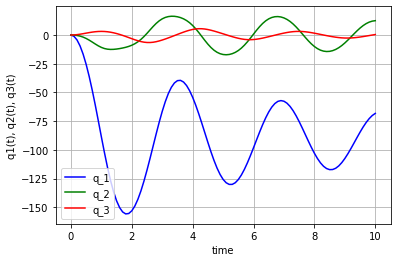

In [4]:
import Animation as anim
import numpy as np
from scipy.integrate import odeint,solve_ivp
import matplotlib.pyplot as plt
from Model import model_nlin_ext
#from Vorsteuerung import *


x0=[-np.pi/2*0,0,0,  0,0,0]       # x0 = [q1,q2,q3,qd1,qd2,qd3]

# define the discretization points
t_start = 0
t_stop = 10
dt = 1e-1

t_sim = np.linspace(t_start, t_stop, int((t_stop - t_start) / dt + 1))


# Define the controller
class Controller:
  def __init__(self,u,t):   
    #from Vorsteuerung import flat_output
    self.ctr = 'nix'
    self.u  = u
    self.t  = t

u=[0,0,0]

controller = Controller(u,t_sim)

#Wrapper für rechte Seite der Differentialgleichung
rhs=lambda t,x:model_nlin_ext(t,x,controller)
    
solOde = solve_ivp(rhs,                  #zu simulierendes Modell
                    [t_start,t_stop],    #Zeitspanne für Simulation
                    x0,                  #Anfangszustand 
                    t_eval=t_sim,        #Auswertungszeitpunkte
                    atol=1e-9,rtol=1e-6  #Toleranzen
                    )


plt.plot(solOde.t, solOde.y[0]*180/np.pi, 'b', label='q_1')
plt.plot(solOde.t, solOde.y[1]*180/np.pi, 'g', label='q_2')
plt.plot(solOde.t, solOde.y[2]*180/np.pi, 'r', label='q_3')
plt.legend(loc='best')
plt.xlabel('time')
plt.ylabel('q1(t), q2(t), q3(t)')
plt.grid()
plt.show()

anim.plot(solOde.y[0],solOde.y[1],solOde.y[2],dt)